In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import math

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Acceso a datos

### Hexagons

In [2]:
schema = 'hexgrid'
folder = 'hexgrid_9_city_2020'
city = 'Guadalajara'
type_area = 'urban'

query = f"SELECT * FROM {schema}.{folder} WHERE \"city\" = \'{city}\' AND \"type\" = \'{type_area}\'"

hex_gdf = aup.gdf_from_query(query)
hex_gdf = hex_gdf.set_crs("EPSG:4326")
print(hex_gdf.shape)
hex_gdf.head(2)

(6540, 6)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban
1,89498c960a3ffff,"POLYGON ((-103.34713 20.62771, -103.34591 20.6...",14039,Guadalajara,Guadalajara,urban


### Censo

In [18]:
schema = 'sociodemografico'
folder = 'censo_inegi_20_ageb_hex'
res = 9

query = f"SELECT * FROM {schema}.{folder} WHERE  \"hex_id\" IN {str(tuple(list(hex_gdf.hex_id_9.unique())))}"
censo_gdf = aup.gdf_from_query(query)

print(censo_gdf.shape)
censo_gdf.head(2)

(5993, 229)


,hex_id,res,geometry,cvegeo,nomgeo,city,type,pobtot,pobfem,pobmas,...,vph_telef,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sinltc,vph_sincint,vph_sintic
0,89498c96e0bffff,9,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban,1298.48220,682.92426,615.5583,...,294.95250,419.64795,380.61142,209.29895,199.624600,95.414460,11.155113,9.975781,55.84028,1.15
1,89498c960a3ffff,9,"POLYGON ((-103.34713 20.62771, -103.34591 20.6...",14039,Guadalajara,Guadalajara,urban,876.05414,451.88855,424.1656,...,144.51299,214.21495,171.54030,117.47235,66.665146,40.243767,1.665511,5.735601,52.73826,0.00


### Delitos

In [6]:
del_gdf = gpd.read_file('../../../data/processed/viviendas_tlajo/delitos/Delitos_AMG_010423_300424_UTM_v1.shp')
del_gdf.head(2)

,fecha,delito,x,y,colonia,municipio,clave_mun,hora,bien_afect,zona_geogr,geometry
0,2023-12-11,Abuso sexual infantil,-103.442246,20.54427,SANTA ANITA,SAN PEDRO TLAQUEPAQUE,98,N.D.,La libertad y la seguridad sexual,AMG,POINT (662397 2272487)
1,2023-12-12,Abuso sexual infantil,-103.038739,20.64929,RESIDENCIAL BUGAMBILIAS ZAPOTLANEJO,ZAPOTLANEJO,124,N.D.,La libertad y la seguridad sexual,AMG,POINT (704334.08 2284568.04)


### Marginalization

In [8]:
schema = 'sociodemografico'
folder = 'margurb_inegi_20_ageb_node'

gdf = hex_gdf.to_crs("EPSG:6372")
gdf = gdf.buffer(1).reset_index().rename(columns={0: "geometry"})
gdf = gdf.set_geometry("geometry")
gdf = gdf.to_crs("EPSG:4326")
poly_wkt = gdf.dissolve().geometry.to_wkt()[0]
query = f"SELECT * FROM {schema}.{folder} WHERE ST_Intersects(geometry, 'SRID=4326;{poly_wkt}')"

nodes_marg = aup.gdf_from_query(query)
nodes_marg = nodes_marg.set_crs("EPSG:4326")
print(nodes_marg.shape)
nodes_marg.head(2)

(126051, 20)


,osmid,x,y,street_count,geometry,cvegeo_mun,cvegeo_loc,cvegeo_ageb,cve_ent,nom_ent,cve_mun,nom_mun,cve_loc,nom_loc,cve_ageb,pobtot,im_2020,gm_2020,imn_2020,city
0,1676031623,-103.342795,20.766141,1,POINT (-103.3428 20.76614),14120,141200001,1412000012789,14,Jalisco,120,Zapopan,0001,Total AGEB urbana,2789,50.666667,118.277968,Alto,0.923943,Guadalajara
1,1676031627,-103.343241,20.766251,1,POINT (-103.34324 20.76625),14120,141200001,1412000012789,14,Jalisco,120,Zapopan,0001,Total AGEB urbana,2789,50.666667,118.277968,Alto,0.923943,Guadalajara


In [9]:
nodes_marg.columns

Index(['osmid', 'x', 'y', 'street_count', 'geometry', 'cvegeo_mun',
       'cvegeo_loc', 'cvegeo_ageb', 'cve_ent', 'nom_ent', 'cve_mun', 'nom_mun',
       'cve_loc', 'nom_loc', 'cve_ageb', 'pobtot', 'im_2020', 'gm_2020',
       'imn_2020', 'city'],
      dtype='object')

## Spatial analysis

### Marginalization

In [10]:
nodes_hex = nodes_marg.overlay(hex_gdf, how='intersection')

nodes_pop = nodes_hex[['hex_id_9','pobtot']].groupby('hex_id_9').sum()
nodes_pop = nodes_pop.reset_index()
nodes_pop = nodes_pop.rename(columns={'pobtot':'pobtot_hex'})

nodes_hex = nodes_hex.merge(nodes_pop, on='hex_id_9')
nodes_hex['pct_pop'] = nodes_hex['pobtot'] / nodes_hex['pobtot_hex']

nodes_hex['wgt_im'] = nodes_hex['pct_pop'] * nodes_hex['im_2020']
nodes_hex['wgt_imn'] = nodes_hex['pct_pop'] * nodes_hex['imn_2020']

nodes_hex = nodes_hex[['hex_id_9','wgt_im','wgt_imn']].groupby(['hex_id_9']).sum()
nodes_hex = nodes_hex.reset_index()

print(nodes_hex.shape)
nodes_hex.head(2)

(5873, 3)


,hex_id_9,wgt_im,wgt_imn
0,89498c86483ffff,118.908615,0.928870
1,89498c86487ffff,117.169406,0.915283


In [11]:
hex_marg = hex_gdf.merge(nodes_hex, on='hex_id_9', how='left')
hex_marg = hex_marg.fillna(0)

### Crime

In [12]:
del_gdf = del_gdf.to_crs("EPSG:4326")
del_hex = del_gdf.overlay(hex_gdf, how='intersection')
del_hex = del_hex.groupby('hex_id_9').count()
del_hex = del_hex.rename(columns={'delito':'delitos_count'})

del_hex = del_hex.reset_index()
del_hex = del_hex[['hex_id_9','delitos_count']]

print(del_hex.shape)
del_hex.head(2)

(4853, 2)


,hex_id_9,delitos_count
0,89498c86483ffff,6
1,89498c86487ffff,6


In [15]:
del_hex = del_hex.merge(censo_gdf[['hex_id','pobtot']], 
                        left_on='hex_id_9', right_on='hex_id',
                        how='outer')
del_hex = del_hex.fillna(0)
del_hex.loc[del_hex.pobtot==0,'pobtot'] = 1
del_hex['del_hab'] = del_hex['delitos_count'] / del_hex['pobtot']
del_hex['del_hab_100'] = del_hex['del_hab'] * 100
hex_crime = hex_gdf.merge(del_hex, on='hex_id_9', how='left')
hex_crime = hex_crime.fillna(0)
print(hex_crime.shape)
hex_crime.head(2)

(6540, 11)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,delitos_count,hex_id,pobtot,del_hab,del_hab_100
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban,26.0,89498c96e0bffff,968.174011,0.026855,2.685468
1,89498c960a3ffff,"POLYGON ((-103.34713 20.62771, -103.34591 20.6...",14039,Guadalajara,Guadalajara,urban,8.0,89498c960a3ffff,295.618744,0.027062,2.706188


<Axes: >

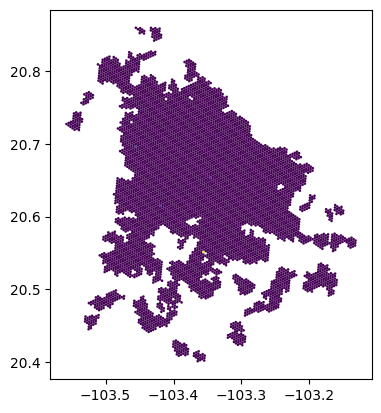

In [16]:
hex_crime.plot('del_hab_100')

### Cars per household

In [19]:
censo_gdf['auto_viv'] = censo_gdf['vph_autom'] / censo_gdf['tvivparhab']

### Socioeconomic level

In [20]:
from sklearn.preprocessing import StandardScaler

def pca(df, columns):
    """Create Principal Component Analysis from DataFrame and return Eigenvalues and Eigenvectors

    Args:
        df {pandas.DataFrame} -- DataFrame containing numeric columns for PCA
        columns {list} -- list with column names for PCA

    Returns:
        numpy.array, numpy.array -- array of Eigenvalues, array of Eigenvectors
    """

    features = np.array(df[columns]).T
    cov_matrix = np.cov(features)
    values, vectors = np.linalg.eig(cov_matrix)

    return values, vectors

def amai_nse(df, group_column_name):
    """Calculate Socioeconomic Levels (NSE) according to AMAI

    Args:
        df {pandas.DataFrame} -- DataFrame containing sociodemographic data for analysis at AGEB level
        df_nse {pandas.DataFrame} -- DataFrame with percentage of population by NSE and state
        state_name {string}: state name

    Returns:
        pandas.DataFrame -- DataFrame containing NSE for the specified state
    """
    #calculate indexes
    df['Idx_PC'] = df['vph_pc'].values / df[['vph_pc','vph_refri','vph_lavad','vph_tv']].max(axis=1)
    df['Idx_School'] = df['graproes'] / df['graproes'].max()
    df['Idx_PosBas'] = df['p18ym_pb'] / df['p_18ymas']

    #remove null in all columns
    idx = (df.Idx_PC.isnull())&(df.Idx_School.isnull())&(df.Idx_PosBas.isnull())
    df = df[~idx].copy()

    #fill missing data
    df['Idx_PC'].fillna((df[['Idx_PC','Idx_School','Idx_PosBas']].mean(axis=1)),inplace=True)
    df['Idx_School'].fillna((df[['Idx_PC','Idx_School','Idx_PosBas']].mean(axis=1)),inplace=True)
    df['Idx_PosBas'].fillna((df[['Idx_PC','Idx_School','Idx_PosBas']].mean(axis=1)),inplace=True)

    #pca
    values, vectors = pca(df, columns=['Idx_PC','Idx_School','Idx_PosBas'])

    #calculate nse index
    df['NSE_Idx'] = df.apply (
        lambda row: (values[0]*vectors[0,0]*row.loc['Idx_PC']+
                    values[0]*vectors[1,0]*row.loc['Idx_School']+
                    values[0]*vectors[2,0]*row.loc['Idx_PosBas']), axis=1)

    #standarize nse index values
    df['NSE_Idx'] = StandardScaler().fit_transform(np.array(df['NSE_Idx']).reshape(-1, 1))

    #sort by nse index
    df.sort_values('NSE_Idx', inplace=True)

    #calculate cumulative population and percentage
    df = df.assign(sum=df.pobtot.cumsum())
    df['pct_pob'] = df['sum'] / df['sum'].max()

    #filter DataFrame
    df = df[[group_column_name,'pobtot','Idx_PC','Idx_School',
    'Idx_PosBas','NSE_Idx']].copy()

    df.columns = df.columns.str.lower()

    # df[[c for c in df if c not in ['geometry']] + ['geometry']]

    return df

In [21]:
hex_nse = amai_nse(censo_gdf, 'hex_id')
hex_nse = hex_gdf.merge(hex_nse, right_on='hex_id',
                        left_on='hex_id_9', how='left')
print(hex_nse.shape)
hex_nse.head(2)

(6540, 12)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,hex_id,pobtot,idx_pc,idx_school,idx_posbas,nse_idx
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban,89498c96e0bffff,1298.48220,0.723622,0.822328,0.752514,-0.848330
1,89498c960a3ffff,"POLYGON ((-103.34713 20.62771, -103.34591 20.6...",14039,Guadalajara,Guadalajara,urban,89498c960a3ffff,876.05414,0.519932,0.654764,0.504339,0.129148


<Axes: >

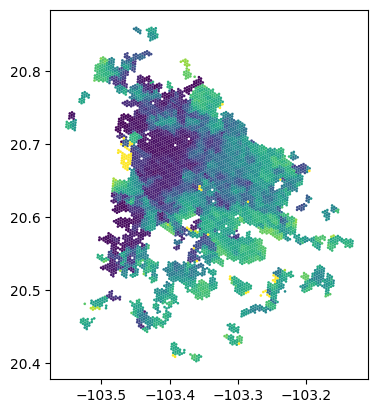

In [22]:
hex_nse.plot('nse_idx')

### Age group

In [23]:
censo_gdf.loc[censo_gdf.pobtot==0,'pobtot'] = 1
censo_gdf['pct_0_17'] = (censo_gdf['pobtot'] - censo_gdf['p_18ymas']) / censo_gdf['pobtot']
censo_gdf['pct_18_59'] = (censo_gdf['p_18ymas'] - censo_gdf['p_60ymas']) / censo_gdf['pobtot']
censo_gdf['pct_60_mas'] = censo_gdf['p_60ymas'] / censo_gdf['pobtot']

### Population density

In [24]:
censo_gdf['dens_pob_ha'] = censo_gdf['pobtot'] / (censo_gdf.to_crs("EPSG:6372").area/10000)

## Merge data

In [25]:
hex_socio = hex_gdf.merge(hex_nse[['hex_id_9','nse_idx']], on='hex_id_9', how='left')
# hex_socio = hex_socio.merge(del_hex[['hex_id_9','delitos_count','del_hab_100']], on='hex_id_9', how='left')
hex_socio = hex_socio.merge(censo_gdf[['hex_id','graproes','dens_pob_ha','auto_viv',
                                      'pct_0_17','pct_18_59','pct_60_mas']], left_on='hex_id_9',
                            right_on='hex_id', how='left')
hex_socio = hex_socio.merge(hex_marg[['hex_id_9','wgt_imn']], on='hex_id_9', how='left')
hex_socio = hex_socio.fillna(0)
print(hex_socio.shape)
hex_socio.head(2)

(6540, 15)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,nse_idx,hex_id,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban,-0.848330,89498c96e0bffff,12.844772,104.98381,0.466357,0.156611,0.636538,0.206851,0.960710
1,89498c960a3ffff,"POLYGON ((-103.34713 20.62771, -103.34591 20.6...",14039,Guadalajara,Guadalajara,urban,0.129148,89498c960a3ffff,10.227421,70.83716,0.562514,0.243964,0.568269,0.187767,0.956838


## Filter data

In [26]:
aoi_gdf = gpd.read_file('../../../data/processed/viviendas_tlajo/AOI_Viviendas_Tlajo.geojson')

In [27]:
if hex_gdf.crs!=aoi_gdf.crs:
    hex_gdf = hex_gdf.to_crs(aoi_gdf.crs)
    print(hex_gdf.crs)

EPSG:32613


In [30]:
hex_clip_id = hex_gdf.clip(aoi_gdf).hex_id_9.unique()
hex_socio_clip = hex_socio.loc[hex_socio.hex_id_9.isin(hex_clip_id)].copy()
print(hex_socio_clip.shape)
hex_socio_clip.head(2)

(133, 15)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,nse_idx,hex_id,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn
1620,8949aa2ea37ffff,"POLYGON ((-103.37917 20.52907, -103.37795 20.5...",14097,Tlajomulco de Zúñiga,Guadalajara,urban,-0.129912,8949aa2ea37ffff,10.818829,73.113032,0.591804,0.320077,0.621625,0.058298,0.966419
1630,8949aa2eac7ffff,"POLYGON ((-103.3676 20.51782, -103.36638 20.51...",14097,Tlajomulco de Zúñiga,Guadalajara,urban,-0.141944,8949aa2eac7ffff,10.977333,49.886642,0.620759,0.370837,0.587962,0.041201,0.966714


## Save data

In [31]:
hex_socio_clip.to_file('../../../data/processed/viviendas_tlajo/hex_sociodemographic.geojson')